In [1]:
import numpy as np
import pandas as pd

The aim is to investigate the Pima Diabetes dataset, construct and optimize a model to predict the presence of diabetes, and finally evaluate the model.<br><br>

<h1> <b> 1. The Dataset </b></h1>
<hr width = "100%"></hr>

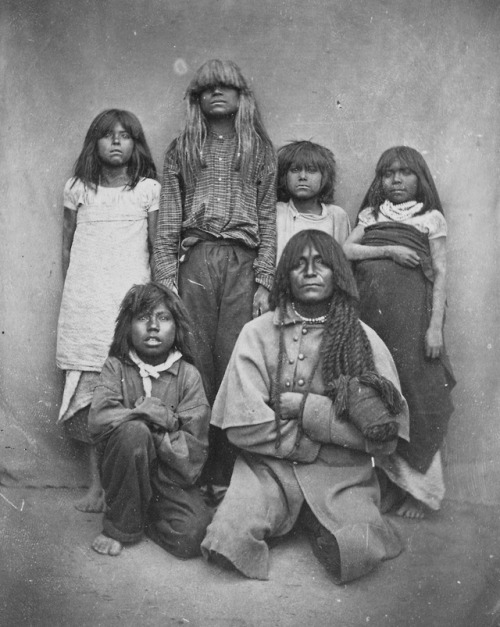

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases.</br>
The <a href = "https://en.wikipedia.org/wiki/Pima_people">Pima</a> are a group of Native Americans living in an area consisting of what is now central and southern Arizona, and it is known for unusually high rates of type II diabetes and obesity. Interesting observations concerning privacy issues regarding this dataset can be found <a href = "https://researchblog.duke.edu/2016/10/24/diabetes-and-privacy-meet-big-data/">here</a>.<br>
It is also relevant to notice that all patients recorded in the dataset are females at least 21 years old.

The dataset consists of the following medical predictors
<ul>
    <li> <b>Pregnancies</b>: Number of past pregnancy
    <li> <b>Glucose</b>: Plasma glucose concentration
    <li> <b>BloodPressure</b>: Diastolic blood pressure, measured in mmHg
    <li> <b>SkinThickness</b>: Triceps skin fold thickness, measured in mm
    <li> <b>Insulin</b>: 2-Hour serum insulin, measured in mu U/ml
    <li> <b>BMI</b>: Body mass index, measured as weight in kg/(height in m)^2
    <li> <b>Diabetes Pedigree Function</b>: This is a function that represents how likely they are to get the disease by extrapolating from their ancestor’s history
    </ul>
The target variable is the variable <b>Outcome</b>, with 0 and 1 denoting a negative and positive diabetes diagnosis, respectively.

In [2]:
#Import the needed libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif


from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score

sns.set_style("dark")

In [6]:
## Import the dataset

data = pd.read_csv("diabetes.csv")

In [7]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [8]:
data.shape

(768, 9)

<h1><b>2. Some basic EDA (Exploratory Data Analysis) </b></h1>
 <hr width = "100%"></hr>

We can start obtaining some basic information concerning the types of variables in the dataset.

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


The variables are all numerical, and there seems to be no missing value. In reality, missing values in all columns apart from Pregnancies and Outcome are repesented by 0.<br> We prefer to substitute these values with the usual NaN representation in NumPy.

In [10]:
to_replace =["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]

def makeNaN(x):
    if x == 0:
        return np.nan
    else:
        return x

for col in to_replace: 
    data[col] = data[col].apply(makeNaN)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   763 non-null    float64
 2   BloodPressure             733 non-null    float64
 3   SkinThickness             541 non-null    float64
 4   Insulin                   394 non-null    float64
 5   BMI                       757 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB


We can see that the columns Insulin and SkinThickness are missing many values. Is dropping them in our model building a good idea? Is it worth proceeding with imputation?<br>
Some data exploration will inform us better.

Since the column Insulin is the one with the most missing values, we can start investigating its distribution via a box plot

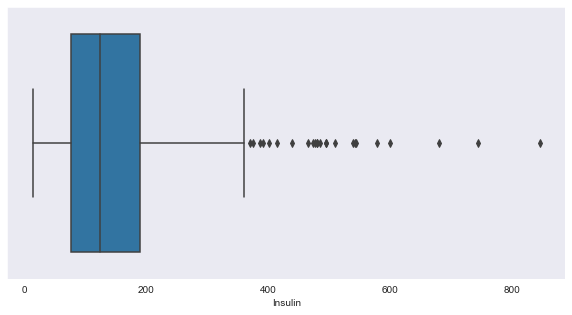

In [11]:
plt.figure(figsize = (10, 5))

sns.boxplot(x = "Insulin", data = data)

We notice the presence of many outliers. Since insulin is used in treating diabetes, we expect higher values among those women of the Pima community affected by diabetes.<br>
It is then worth checking for the average value  of insulin in the two groups, i.e. affected and not affected by diabetes.

In [12]:
data[["Insulin", "Outcome"]].groupby("Outcome").mean()

,Insulin
Outcome,
0,130.287879
1,206.846154


We notice that the average level of insulin are consistent with diabetes diagnoses. See for instance <a href="https://www.healthline.com/health/diabetes/insulin-resistance-symptoms">here</a>.<br>
We can also check how many missing values are present between the two groups.

In [13]:
data[data["Insulin"].isnull()]["Outcome"].value_counts()

0    236
1    138
Name: Outcome, dtype: int64

We can see that the missing values are not equally distributed between the two groups. Maybe tests were done after symptoms appeared?<br>
We can now consider a boxplot for the rest of the relevant columns

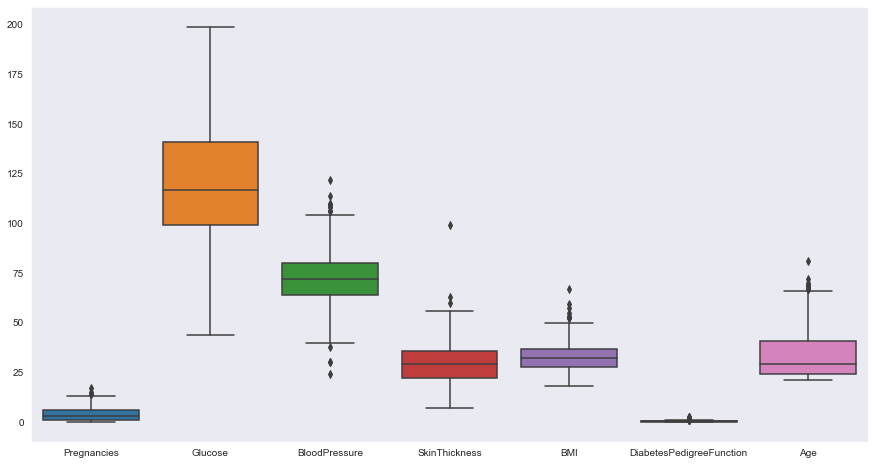

In [14]:
plt.figure(figsize = (15, 8))

sns.boxplot(data = data[["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "BMI", "DiabetesPedigreeFunction", "Age"]])

We see that there are few outliers, but nothing out of the ordinary, apart from possibly the column Skin Thickness.<br>
We can gain more insight in the Pima women community by looking at the distribution of age

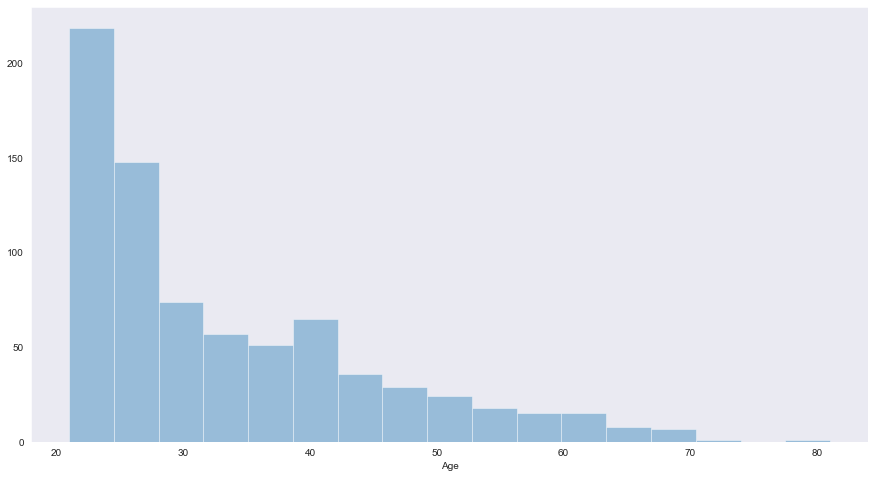

In [15]:
plt.figure(figsize = (15, 8))

sns.distplot(a = data["Age"], kde = False)

How are the various medical predictors correlated?<br>
To answer this question we can inspect the correlation matrix which is associated to the dataset

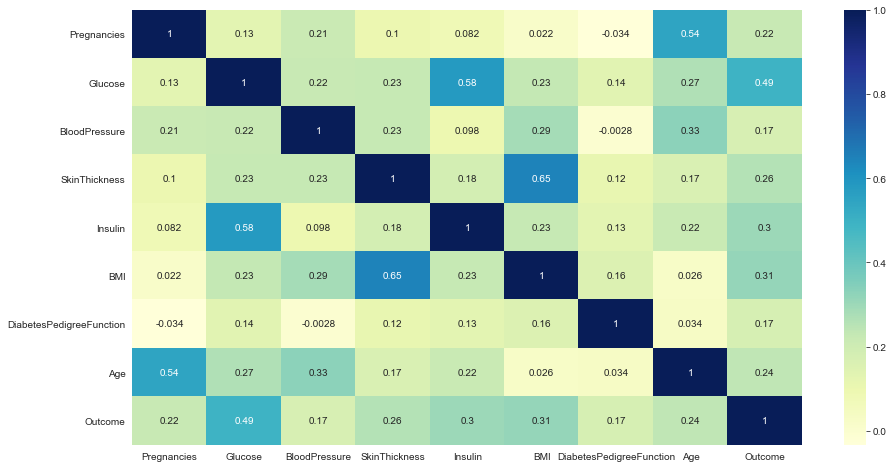

In [16]:
plt.figure(figsize = (15, 8))
sns.heatmap(data = data.corr(), annot = True, cmap="YlGnBu")

We can see that all the medical predictors are positively correlated with the target column, in particular the Glucose, BMI and Insulin.<br>
The following scatter plots explore the relationship between Glucose and Insulin, and between BMI and Skin Thickness, both quite expected.

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


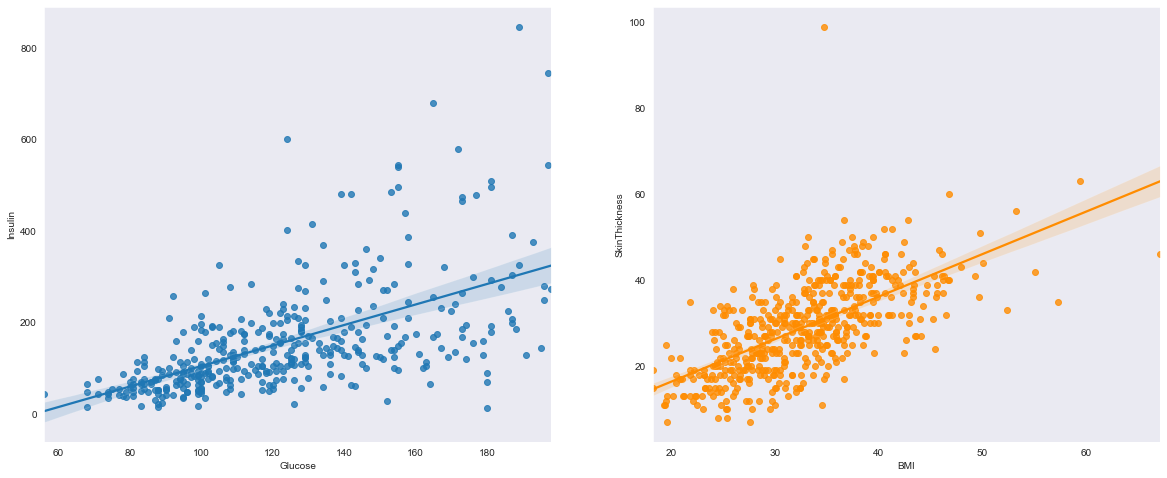

In [17]:

fig, ax = plt.subplots(1,2, figsize = (20, 8))
sns.regplot(x = "Glucose", y = "Insulin", data = data, ax = ax[0])
sns.regplot(x = "BMI", y = "SkinThickness", data = data, ax = ax[1], color = "darkorange")
fig.show()

The scatterplot on the right reveals a data point with an outlying value of Skin Thickness.<br>
We can investigate this entry more

In [23]:
data[data["SkinThickness"] > 70]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
579,2,197.0,70.0,99.0,NaN,34.7,0.575,62,1


We can check the average Skin Thickness value for data points which have similar Glucose values

In [24]:
data[(data["SkinThickness"] < 99) & (data["Glucose"] > 150) & (data["Glucose"] < 250)]["SkinThickness"].mean()  

32.36

Similarly, we can check the average Skin Thickness for similar values of Blood Pressure

In [25]:
data[(data["SkinThickness"] < 99) & (data["BloodPressure"] > 50) & (data["BloodPressure"] < 100)]["SkinThickness"].mean()  

29.114

The results point all in the direction of an outlying value, possibly a corrupted data point.

What about the BMI? The <b>body mass index</b> is used as a "convenient rule of thumb used to broadly categorize a person as <em>underweight, normal weight, overweight</em>, or obese based on tissue mass and height". See <a href = "https://en.wikipedia.org/wiki/Body_mass_index">here</a>.<br>
We can visualize the BMI data in terms of these four categories

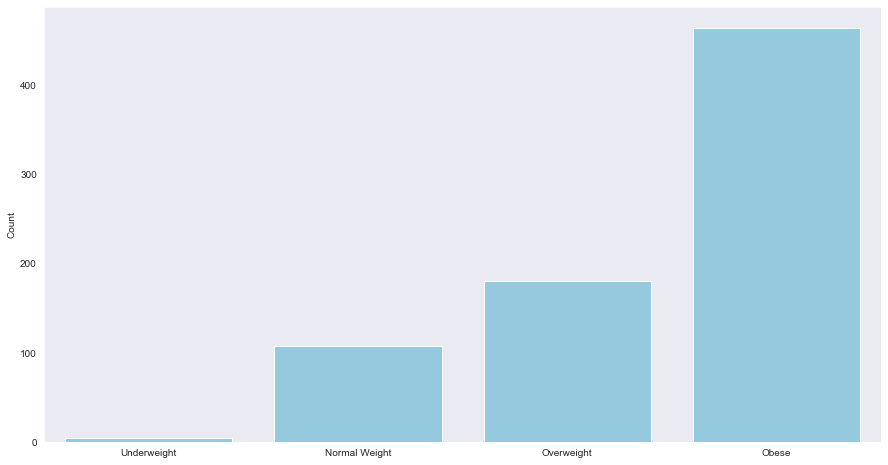

In [26]:
BMI_cat = pd.cut(data["BMI"], bins=(0, 18.5, 25, 30, 100), labels=["Underweight", "Normal Weight", "Overweight", "Obese"])
plt.figure(figsize = (15, 8))
sns.barplot(x = ["Underweight", "Normal Weight", "Overweight", "Obese"], y = BMI_cat.value_counts().sort_index(), color = "skyblue")
plt.ylabel("Count")
plt.show()

We can see that a great number of the (female) Pima members would be categorized as "obese". Notice though that the BMI index has several <a href = "https://en.wikipedia.org/wiki/Body_mass_index#Limitations">limitations</a> as a statistical index.<br>
The following swarm bee plot suggests also that BMI is not strongly related to diabetes

D:\Anaconda\lib\site-packages\seaborn\categorical.py:1311: RuntimeWarning: invalid value encountered in less
  off_low = points < low_gutter
D:\Anaconda\lib\site-packages\seaborn\categorical.py:1315: RuntimeWarning: invalid value encountered in greater
  off_high = points > high_gutter


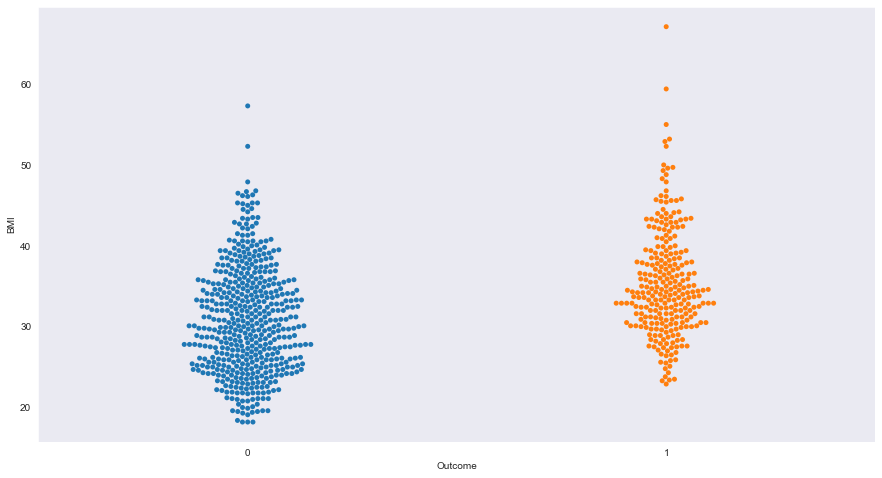

In [27]:
plt.figure(figsize = (15, 8))
sns.swarmplot(y = "BMI", x = "Outcome", data = data)

# 3. Feature Engineering and Selection
<hr width = "100%"></hr>

<b>Imputation and Scaling</b>

We have discussed how the column SkinThickness, Insulin, and BMI seem to be relevant for the prediction of diabetes diagnoses, though they present missing values.<br>
We will use different strategies to impute the missing values.

To avoid data leakage, we first split our dataset into a training and a testing part, and perform imputation separately.<br>
Notice that we perform a <em>stratified</em> train-test split: this is needed, since the dataset is unbalanced.

In [28]:
y = data["Outcome"]
X = data.drop(["Outcome"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 5)
print("The train set contains ", X_train.shape[0]," samples")
print("The test set contains ", X_test.shape[0]," samples")

The train set contains  614  samples
The test set contains  154  samples


We will start with a baseline model, which will help us also to understand how to treat the various features.<br> 
We will impute the missing values with the mean. For this aim, we set up an imputer which we will use in a <b>pipeline</b> later.<br>
Since linear models are sensitive to scaling, we also set up a standard scaler.

In [29]:
imputer = SimpleImputer(strategy = "mean")
scaler = StandardScaler()

<b>Baseline model</b>

We will use 5-fold cross validation to validate our model. using the accuracy metric. To avoid data leakage, we will use a simple pipeline which includes preprocessing. 

In [30]:
model = LogisticRegression()

pipeline = Pipeline(steps = [
        ("imputing", imputer),
        ('scaling', scaler),
        ("model", model)
        ])


scores = cross_val_score(pipeline, X_train, y_train, cv = 5, scoring = "accuracy")

print("The average score is: ", scores.mean())
print("The standard deviation is: ", scores.std())

The average score is:  0.7751965880314541
The standard deviation is:  0.024920926340867643


Notice that the above score does not show the training score in each fold. Cheking the average gap between training score and validation score in a <b>given</b> fold could give us some hint about the variance of the baseline model.<br>
Notice that comparing the training error of the model fitted on  (X_train, y_train) with the cross validation score is <b>not</b> advised, since the cross validation estimator is not really estimating the <em>conditional error</em> of the model, rather its <em>unconditionale error</em>. <br>
We can obtain this info as follows

In [31]:
scores = cross_validate(pipeline, X_train, y_train, cv = 5, scoring = "accuracy", return_train_score = True)

train_scores = scores["train_score"]
val_scores = scores["test_score"]

gap = np.abs(np.subtract(train_scores, val_scores))

print("The average gap between training and validation fold is: ", gap.mean())
print("The standard deviation of the gaps is: ", gap.std())


The average gap between training and validation fold is:  0.031725571821509015
The standard deviation of the gaps is:  0.006038238351804453


We notice how the mean gap is relatively small, even if the standard deviation is not neglegible.<br>
It is worth giving a look at the classification report for the model trained on (X_train, y_train)

In [32]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_train)
report = classification_report(y_train, y_pred)
print("The classification report on the training set is: ")
print()
print(report)

The classification report on the training set is: 

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       400
           1       0.73      0.59      0.66       214

    accuracy                           0.78       614
   macro avg       0.77      0.74      0.75       614
weighted avg       0.78      0.78      0.78       614



Notice how the model has better precision and recall on the label 0 rather then the label 1. This is possibly due to the fact that the dataset is unbalanced with respect to the target label.

<b>Regression imputation</b>

We can try to do a better imputation on Insulin. Given that a lot of values are missing, we can try to impute them via a regression using a regression on another predictor, more specifically "Glucose", given the correlation value. In this way, we might get a more sensible result.

In [33]:
to_impute = list(X.columns)
to_impute.remove("Insulin")
regr_imp = IterativeImputer(random_state=0)

imputing = ColumnTransformer(transformers=
                                 [('imputing', imputer, to_impute ),
                                 ('regression', regr_imp, ["Glucose", "Insulin"]),
                                 ])

pipeline_imputing = Pipeline(steps = [
        ("imputing", imputing),
        ('scaling', scaler),
        ("model", model)
        ])


scores = cross_val_score(pipeline_imputing, X_train, y_train, cv = 5, scoring = "accuracy")
print("The average score is: ", scores.mean())
print("The standard deviation is: ", scores.std())

The average score is:  0.7719312275089965
The standard deviation is:  0.025230355115832787


The regressiong imputing gives a slightly lower cross-validation score.

<b>Interactions</b>

We can try at this point to add a few <b>interactions</b>, to see if we can increase our baseline model performance, and possible perform some feature selection.

In [34]:
cols = list(X.columns)

poly = PolynomialFeatures(2, include_bias = False)

model = LogisticRegression()

interaction = ColumnTransformer(transformers=
                                 [('imputing', imputer, to_impute ),
                                 ('regression', regr_imp, ["Glucose", "Insulin"])
                                 
                                 ])

pipeline_int = Pipeline(steps = [
        ("interaction", interaction),
        ("scaling", scaler),
        ('inter', poly),
        ("model", model)
        ])


scores = cross_val_score(pipeline_int, X_train, y_train, cv = 5, scoring = "accuracy")

print("The average score is: ", scores.mean())
print("The standard deviation is: ", scores.std())


The average score is:  0.758963081434093
The standard deviation is:  0.0254407787022531


We can see that adding degree 2 interactions has not improved much the average validation scores, but on the other hand it has increased the standard deviation, making the model more unstable. Adding interactions does not seem to help.

<b>Feature selection</b>

We can now ask how much each feature contributes to the variance of the classifier response. In particular, we can perform an F-test to investigate which are the most relevant feature. Though our model does not contain many predictors, it is worthwile to explore 

In [35]:
cols = list(X.columns)

poly = PolynomialFeatures(2, include_bias = False)

model = LogisticRegression()

interaction = ColumnTransformer(transformers=
                                 [('imputing', imputer, to_impute ),
                                 ('regression', regr_imp, ["Glucose", "Insulin"])
                                 
                                 ])

pipeline_int = Pipeline(steps = [
        ("interaction", interaction),
        ("scaling", scaler),
        ('inter', poly),
        ("select", SelectKBest(f_classif, k=3 )),
        ("model", model)
         ])


scores = cross_val_score(pipeline_int, X_train, y_train, cv = 5, scoring = "accuracy")

print("The average score is: ", scores.mean())
print("The standard deviation is: ", scores.std())


The average score is:  0.7541116886578703
The standard deviation is:  0.02038131752223191


The selection mechanism provided by SelectKBest does not seem to improve our model. This was expected, since the number of features present in our model is quite reduced.

<b>Conclusion</b>

After some experimenting, we can see that the cross validation performance of the baseline model is not much affected by different imputation method, interactions or feature selection.<br>
Following a parsimony principle, we can then consider the following to be our baseline model.

In [36]:
model = LogisticRegression()

pipeline = Pipeline(steps = [
        ("imputing", imputer),
        ('scaling', scaler),
        ("model", model)
        ])


scores = cross_val_score(pipeline, X_train, y_train, cv = 5, scoring = "accuracy")

print("The average score is: ", scores.mean())
print("The standard deviation is: ", scores.std())

The average score is:  0.7751965880314541
The standard deviation is:  0.024920926340867643


# 4. Model Refining
<hr width = "100%"></hr>

Having established a baseline model, we will explore and compare different learning algorithms. More precisely, we will use a nested grid search for hyperparameters optimization, to avoid overfitting the validation test.<br> We will used stratified cross validation, both for the inner and the outer loop in the grid search.<br>
The learning algorithms we will test are Random Forest Classifier, KNN Classifier, Logistic Regression and Support Vector Machine. for each of these algorithms, we will provide the training and validation score for each fold in the outer cross-validation loop. 

In [37]:

inner_cv = StratifiedKFold(n_splits=5, shuffle = True)
outer_cv = StratifiedKFold(n_splits=10, shuffle = True)

model_scores = {"train": [],
                "test": []
               }

models = [
    {
        "name": "Rand Forest Classifier",
        "estimator": RandomForestClassifier(),
        "params": {
                    "n_estimators": range(50, 200, 50),
                    "max_depth": [1, 3, 5], 
                    "random_state": [48]
                      }
    },
    
    {
        "name": "KNN Classifier",
        "estimator": KNeighborsClassifier(),
        "params": {
                    "n_neighbors": [3,5,7,10],
                    }
    },
    
    {
        "name": "Logistic Regression",
        "estimator": LogisticRegression(),
        "params": {
                    "C": [0.01, 0.1, 1, 10, 100, 1000],
                    "random_state": [48]
                }
    },
    
    {
        "name": "Support Vector Machine",
        "estimator": SVC(),
        "params": {
                    "C": [0.01, 0.1, 1, 10, 100, 1000],
                    "gamma": ["auto"],
                    "random_state": [48]
                }
    }
    
    ]

for alg in models:

    model = GridSearchCV(alg["estimator"], alg["params"], scoring ="accuracy", cv = inner_cv)

    pipeline = Pipeline(steps = [
        ("imputing", imputer),
        ('scaling', scaler),
        ("model", model)
        ])




    scores = cross_validate(pipeline, X_train, y_train, cv =  outer_cv, return_train_score = True)

    train_scores = np.array(scores["train_score"])
    test_scores = np.array(scores["test_score"])
    
    print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
    print()
    print(alg["name"])
    print("The average  training score is:", train_scores.mean())
    print("The standard deviation of the training score is:", train_scores.std())
    print()
    print("The average  validation score is:", test_scores.mean())
    print("The standard deviation of the validation score is:", test_scores.std())
    print()
    
    model_scores["train"].append(train_scores.mean())
    model_scores["test"].append(test_scores.mean())


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Rand Forest Classifier
The average  training score is: 0.8356743192598998
The standard deviation of the training score is: 0.0253094206573588

The average  validation score is: 0.7573506081438393
The standard deviation of the validation score is: 0.042470272348104125

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

KNN Classifier
The average  training score is: 0.8172330764997249
The standard deviation of the training score is: 0.012771096214450483

The average  validation score is: 0.7394764674775252
The standard deviation of the validation score is: 0.02334222428647326

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Logistic Regression
The average  training score is: 0.7783234399979034
The standard deviation of the training score is: 0.005966017982106159

The average  validation score is: 0.7754098360655738
The standard deviation of the validation score is: 0.04062864656407524

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Support Vector Machine
The average  training score is: 0.8

We can plot the average validation results for the different classifiers.

In [38]:
model_scores["train"]

[0.8356743192598998,
 0.8172330764997249,
 0.7783234399979034,
 0.8260961291506146]

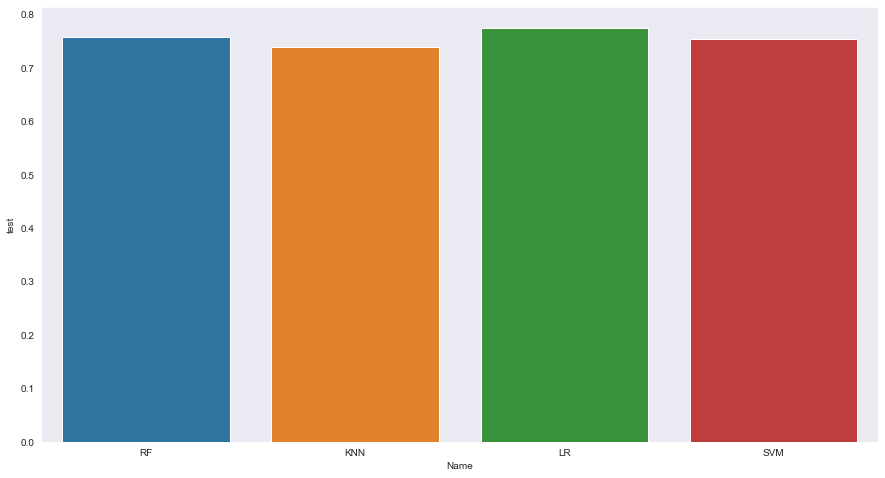

In [39]:
scores_data = pd.DataFrame({"Name" : ["RF", "KNN", "LR", "SVM"],
                            "train": model_scores["train"],
                            "test": model_scores["test"]
                           })

plt.figure(figsize = (15, 8))
sns.barplot(x = "Name", y = "test", data = scores_data)
